In [55]:
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import simulator
import alu_dataset
import plain_net
import model_training
import ablated_pbm
import model_evaluation

# Generate dataset

In [56]:
x_range = np.array([[2060,4460], [2,5], [9,13], [11500,16000],[9750,10000],[960,990], [790,850],[555,610]]).T

simulator.generate_dataset(x_range,n_sim=40, folder_name='new_folder', name='trainingset',n_sim_steps=5000, DT=10, mode='random')

simulator.generate_dataset(x_range,n_sim=100, folder_name='new_folder', name='testset',n_sim_steps=5000, DT=10, mode='random')

Simulation number %d succeeded 0
Simulation number %d succeeded 1
Simulation number %d succeeded 2
Simulation number %d succeeded 3
Simulation number %d succeeded 4
Simulation number %d succeeded 5
Simulation number %d succeeded 6
Simulation number %d succeeded 7
Simulation number %d succeeded 8
Simulation number %d succeeded 9
Simulation number %d succeeded 10
Simulation number %d succeeded 11
Simulation number %d succeeded 12
Simulation number %d succeeded 13
Simulation number %d succeeded 14
Simulation number %d succeeded 15
Simulation number %d succeeded 16
Simulation number %d succeeded 17
Simulation number %d succeeded 18
Simulation number %d succeeded 19
Simulation number %d succeeded 20
Simulation number %d succeeded 21
Simulation number %d succeeded 22
Simulation number %d succeeded 23
Simulation number %d succeeded 24
Simulation number %d succeeded 25
Simulation number %d succeeded 26
Simulation number %d succeeded 27
Simulation number %d succeeded 28
Simulation number %d suc

# Load newly generated dataset

In [57]:
with open('new_folder/trainingset.pickle', 'rb') as handle:
    data = pickle.load(handle)

with open('new_folder/trainingsetV_cell.pickle', 'rb') as handle:
    V_cell = pickle.load(handle)

with open('new_folder/trainingsetT_liq.pickle', 'rb') as handle:
    T_liq = pickle.load(handle)

In [58]:
with open('new_folder/testset.pickle', 'rb') as handle:
    test = pickle.load(handle)

with open('new_folder/testsetV_cell.pickle', 'rb') as handle:
    V_cell = pickle.load(handle)

with open('new_folder/testsetT_liq.pickle', 'rb') as handle:
    T_liq = pickle.load(handle)

# Create dataset objects

In [59]:
DT = 10
#dataset = alu_dataset.Dataset_alu(data,DT)
dSetSize = [40]

DATASETS_DDM = []
for i in range(len(dSetSize)):
    DATASETS_DDM.append(alu_dataset.Dataset_alu(data[0:dSetSize[i],:,:],DT))

# DDM

## Training

In [60]:
# DDM train
no_models = 10
l1_lambda = 1e-4
l1_lam_in = 1e-4
lr = 1e-3

In [61]:
plain_sparse = nn.ModuleList()
plain_sparse_trainStep = []

plain_dense = nn.ModuleList()
plain_dense_trainStep = []

In [62]:
for i in range(len(DATASETS)):
   PS = nn.ModuleList()
   PS_TS = []

   PD = nn.ModuleList()
   PD_TS = []

   for j in range(no_models):

      PS.append(plain_net.NN(13,20,20,20,20,8))
      PS_TS.append(model_training.model_preparation(PS[j],'Adam',l_r=lr,lambda_l1=l1_lambda,lambda_in=l1_lam_in))

      PD.append(plain_net.NN(13,20,20,20,20,8))
      PD_TS.append(model_training.model_preparation(PD[j],'Adam',l_r=lr,lambda_l1=0.0))

   plain_sparse.append(PS)
   plain_sparse_trainStep.append(PS_TS)

   plain_dense.append(PD)
   plain_dense_trainStep.append(PD_TS)

In [63]:
num_epochs = 100

for i in range(len(DATASETS)):
        training_loader = DataLoader(DATASETS[i], batch_size=128, shuffle=True)
         
        for epoch in range(num_epochs):
                for (x_batch, y_batch) in training_loader:
                        for j in range(no_models):
                            plain_sparse_trainStep[i][j](x_batch,y_batch)
                            plain_dense_trainStep[i][j](x_batch,y_batch)

## DDM Testset forecast

In [64]:
# DDM
X_est_plainDense = []
X_est_plainSparse = []

no_datasets = len(DATASETS)

for i in range(no_datasets):
    print(i)
    X_est_plainDense.append(
        model_evaluation.multi_models_testSet_estimate(
            test, plain_dense[i], DT, DATASETS[i]
        )
    )
    X_est_plainSparse.append(
        model_evaluation.multi_models_testSet_estimate(
            test, plain_sparse[i], DT, DATASETS[i]
        )
    )


0


# CoSTA

## Generate manipulated dataset for training using the PBM

In [65]:
#PBM
RK4_PBM,Volt_Tliq_pbm_fun, f_pbm = ablated_pbm.ablated_PBM_RK4()

dSetSize = [40]

DATASETS_residual = []
for i in range(len(dSetSize)):
    #Simulated data
    X_true = data[0:dSetSize[i],:,:]

    # Time derivative at each time step calculated by misspecified PBM
    X_dot_pbm = ablated_pbm.dXdt_pbm(X_true, f_pbm)

    #Make dset objects for residual data
    DATASETS_residual.append(alu_dataset.residual_dataset_alu(X_true,X_dot_pbm,DT,feature_normalization='std_norm'))


## Training

In [66]:
no_models = 10
l1_lambda = 1e-4
l1_lam_in = 1e-4
lr = 1e-3

corr_plain_sparse = nn.ModuleList()
corr_plain_sparse_trainStep = []

corr_plain_dense = nn.ModuleList()
corr_plain_dense_trainStep = []


for i in range(len(DATASETS)):

   corr_PS = nn.ModuleList()
   corr_PS_TS = []

   corr_PD = nn.ModuleList()
   corr_PD_TS = []

   for j in range(no_models):

      corr_PS.append(plain_net.NN(13,20,20,20,20,8))
      corr_PS_TS.append(model_training.model_preparation(PS[j],'Adam',l_r=lr,lambda_l1=l1_lambda,lambda_in=l1_lam_in))

      corr_PD.append(plain_net.NN(13,20,20,20,20,8))
      corr_PD_TS.append(model_training.model_preparation(PD[j],'Adam',l_r=lr,lambda_l1=0.0))

   corr_plain_sparse.append(PS)
   corr_plain_sparse_trainStep.append(PS_TS)

   corr_plain_dense.append(PD)
   corr_plain_dense_trainStep.append(PD_TS)


In [67]:
num_epochs = 100

for i in range(len(DATASETS)):
    training_loader = DataLoader(DATASETS_residual[i], batch_size=128, shuffle=True)
         
    for epoch in range(num_epochs):
        for (x_batch, y_batch) in training_loader:
            for j in range(no_models):
                corr_plain_sparse_trainStep[i][j](x_batch,y_batch)
                corr_plain_dense_trainStep[i][j](x_batch,y_batch)

## Costa testset forecast

In [68]:
X_est_COSTA_plainDense = []
X_est_COSTA_plainSparse = []


DT = 10
no_datasets = len(DATASETS)

for i in range(no_datasets):
    print(i)
    X_est_COSTA_plainDense.append(model_evaluation.COSTA_testSet_estimate(test, f_pbm, corr_plain_dense[i],10,DATASETS_residual[i],feature_normalization='std_norm'))
    X_est_COSTA_plainSparse.append(model_evaluation.COSTA_testSet_estimate(test, f_pbm, corr_plain_sparse[i],10,DATASETS_residual[i],feature_normalization='std_norm'))



0


# Testset Results

In [69]:
# Forecast PBM 
X_est_PBM = ablated_pbm.RollingForecast_pbm(test=test, RK4 =RK4_PBM, DT=10)


Volt_Tliq_pbm_est = ablated_pbm.Voltage_liquidus_temp_pbm(X_pbm_RF=X_est_PBM,volt_T_liq_pbm=Volt_Tliq_pbm_fun)

torch.Size([5000, 13])


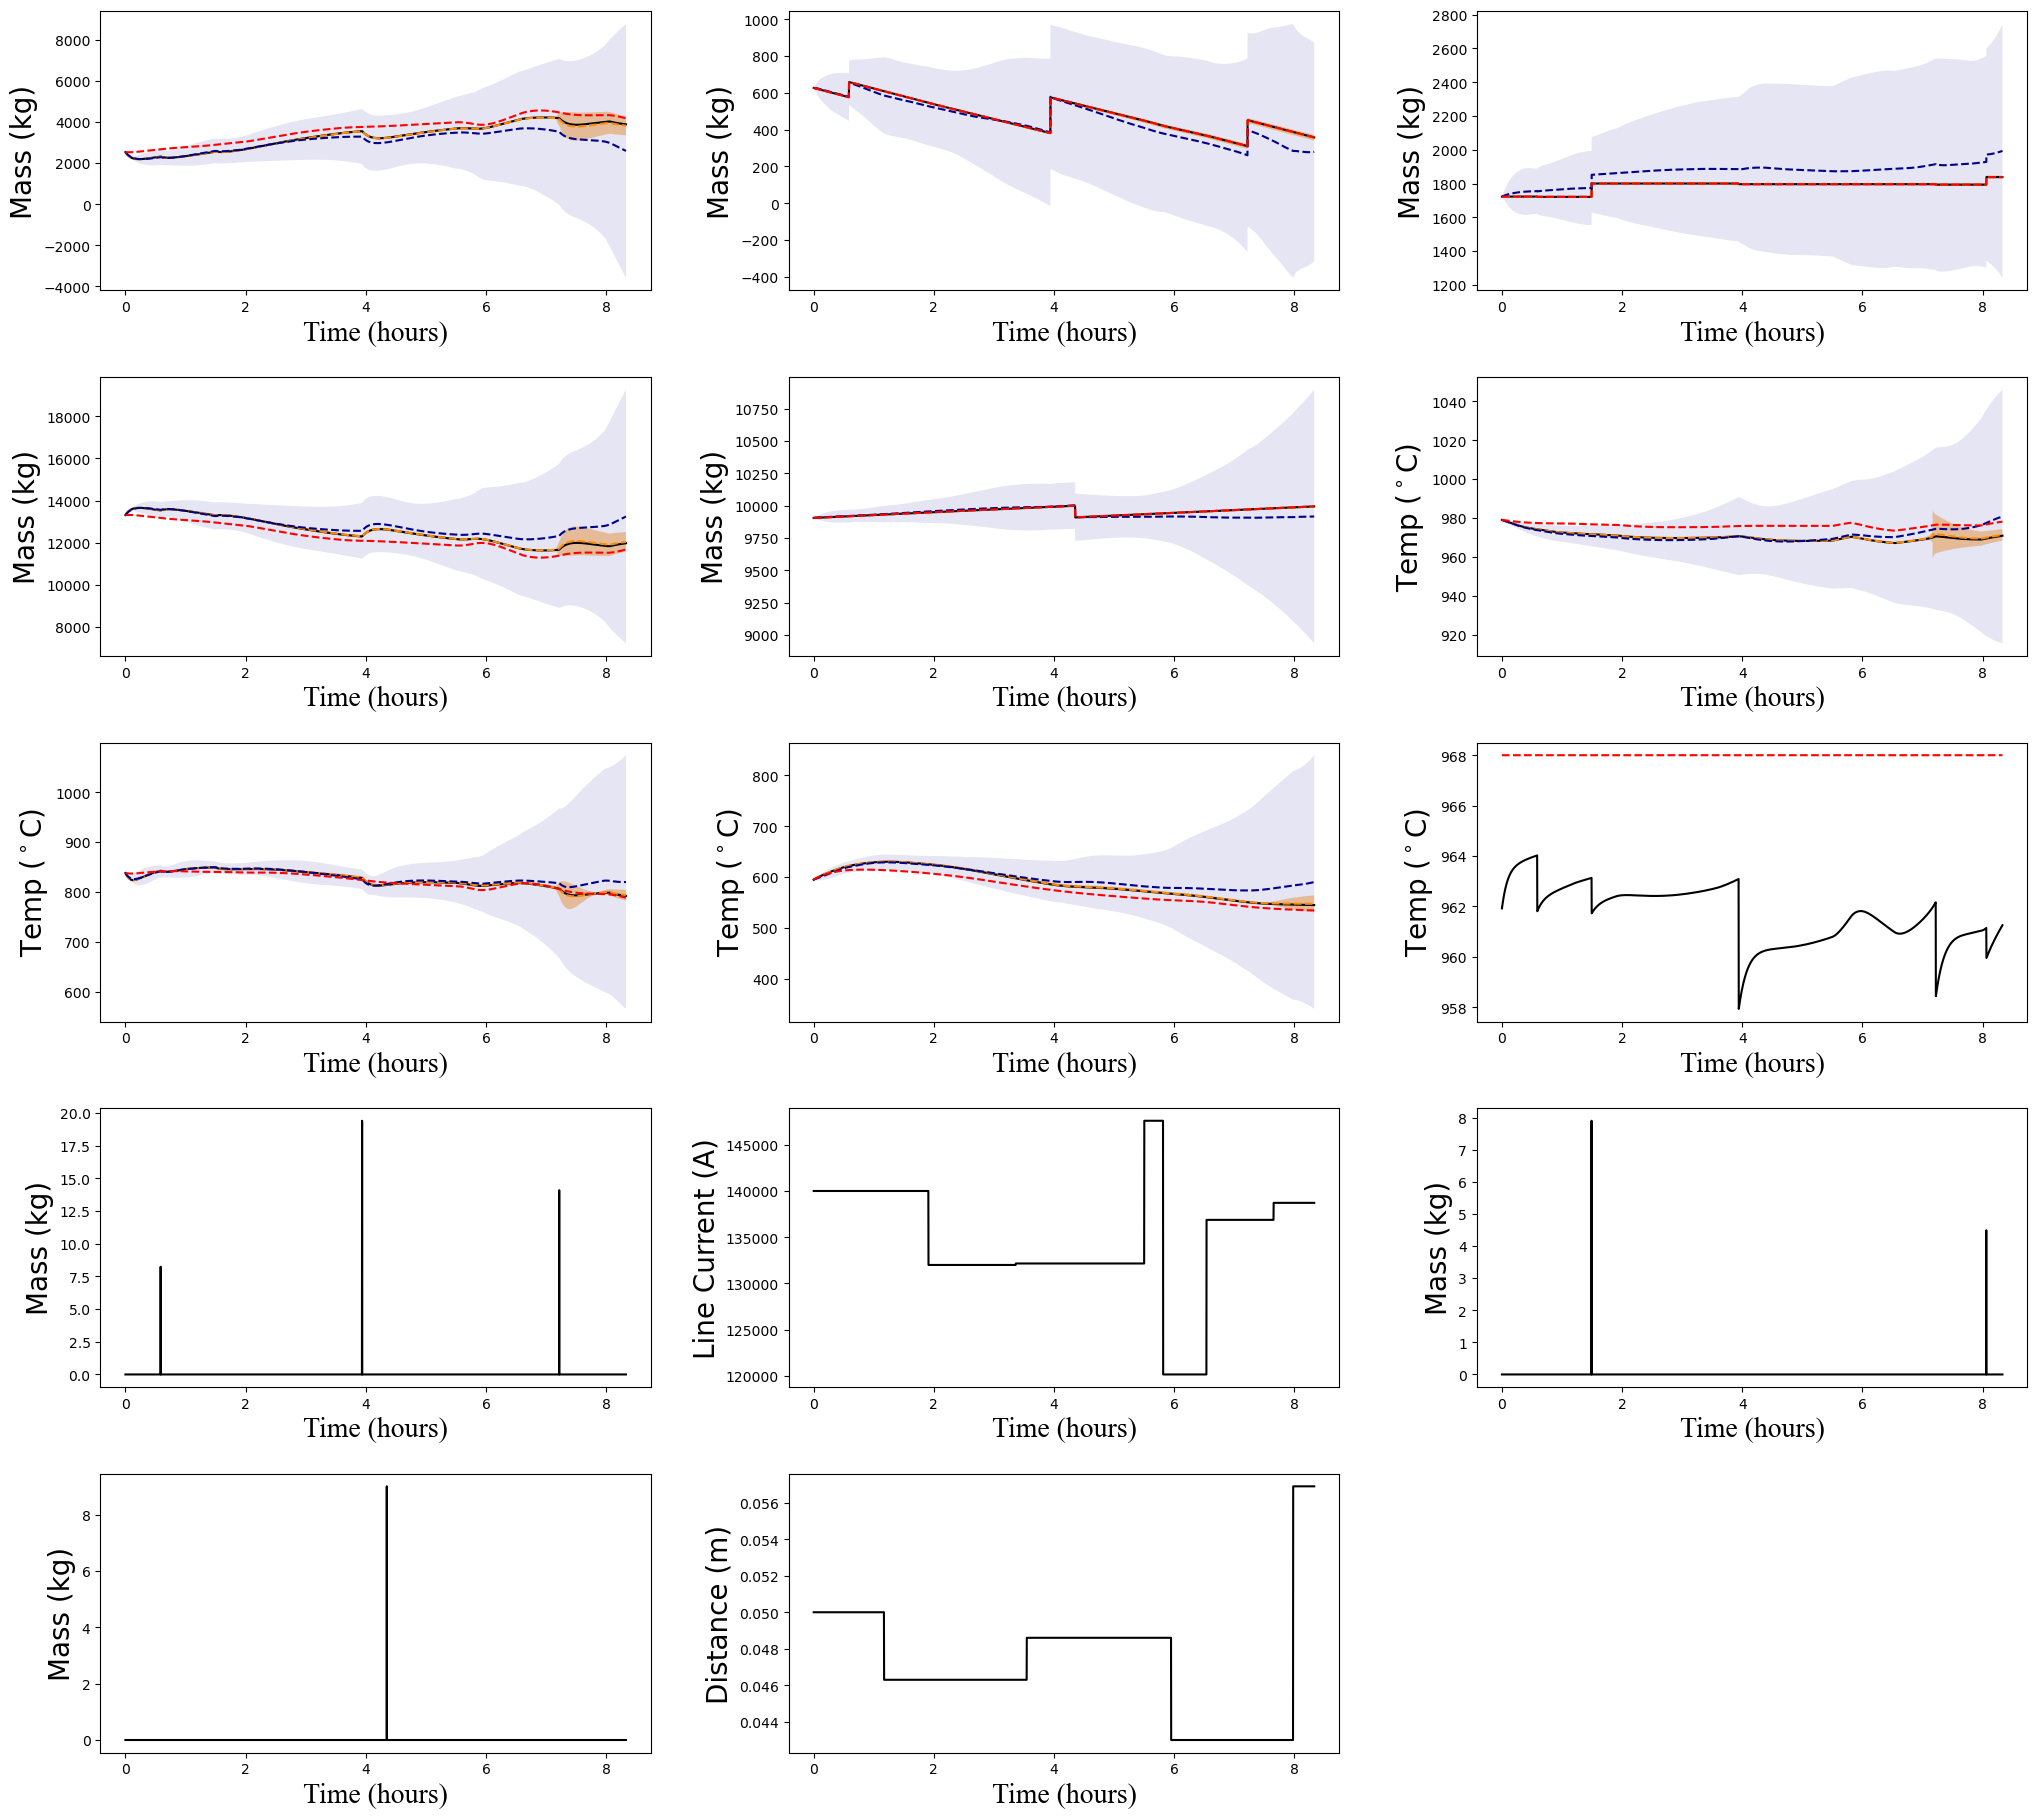

In [82]:
fig_trajectory_forecasts = model_evaluation.testset_estimate_trajectory(test, X_est_costa=X_est_COSTA_plainSparse, X_est_DDM=X_est_plainSparse, X_est_PBM=X_est_PBM,\
                                Tliq=T_liq, Volt_Tliq_pbm=Volt_Tliq_pbm_est, sim_num=40, dSet_no=0, start_ind=0, end_ind=3000, DT=10)

In [76]:
hor = np.array([0,100, 2500, 5000])
no_of_horizons = len(hor)-1
dSet = 0
RFMSE_multi_horizon, Divergence_multi_horizon = model_evaluation.lists_of_RFMSE_val(testset=test, hor=hor,no_of_horizons=no_of_horizons,X_est_costa_dense=X_est_COSTA_plainDense,\
                                                                    X_est_costa_sparse=X_est_COSTA_plainSparse,X_est_DDM_dense=X_est_plainDense,\
                                                                    X_est_DDM_sparse=X_est_plainSparse,DATASETS=DATASETS, X_est_PBM=X_est_PBM,dset_no=0)

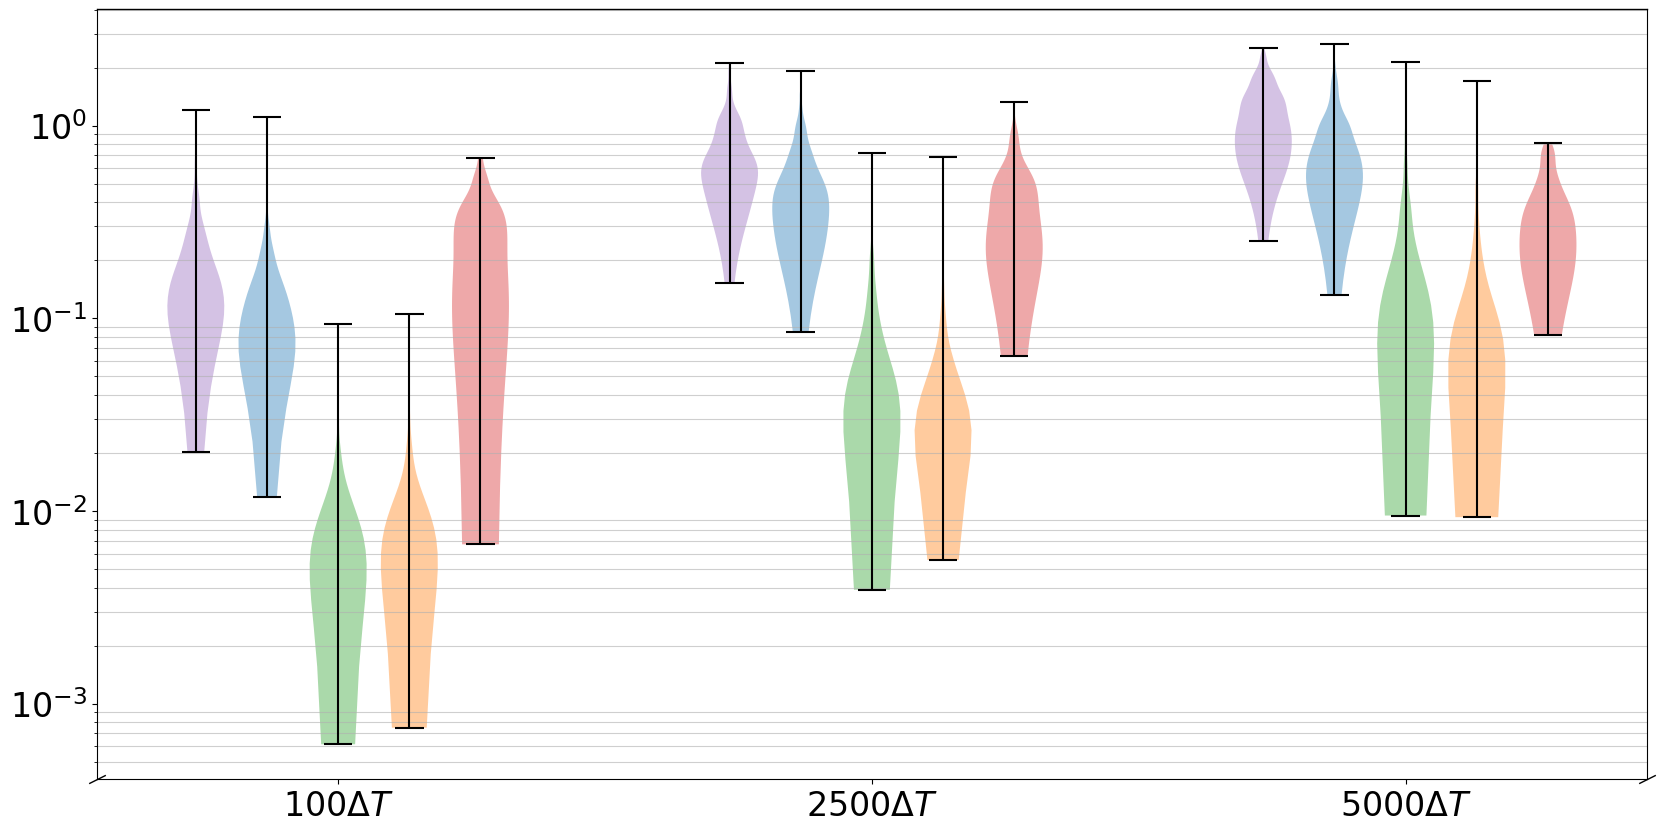

In [77]:
horizons = [100, 2500, 5000]
fig_violin = model_evaluation.RFMSE_violin_multi_horizon_plot(RFMSE_multi_horizon, horizons, log=True)

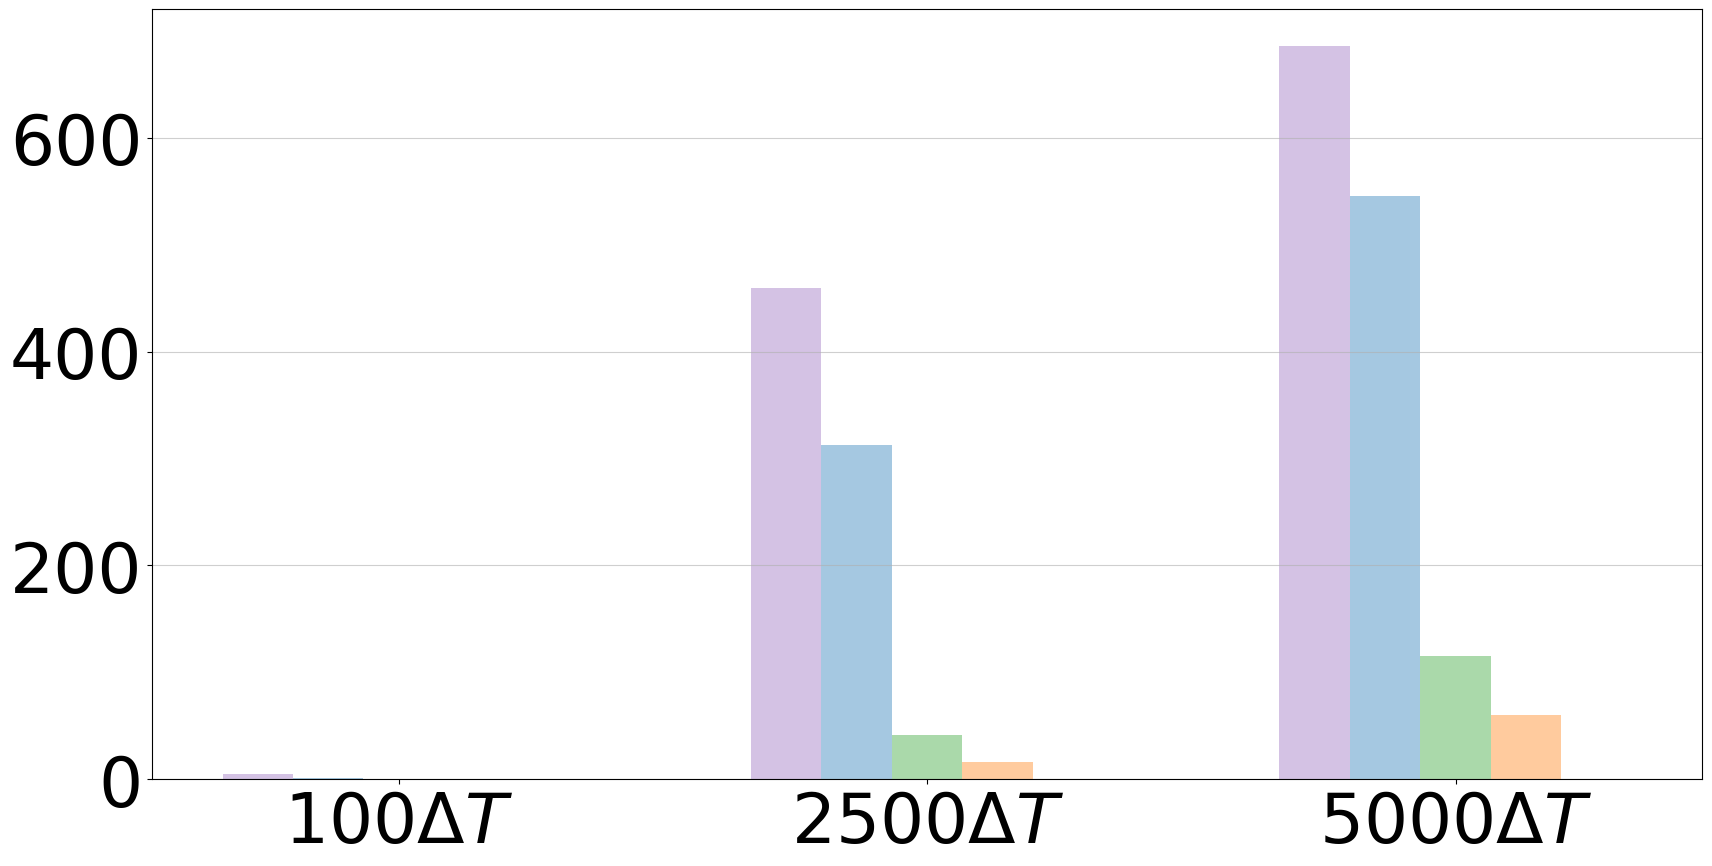

In [78]:
fig_divergence = model_evaluation.divergence_plot_multi_horizons(Divergence_multi_horizon, horizons,labelsize=50)